In [ ]:
# L 4-30-25
# notebooks/classify_new_song.ipynb

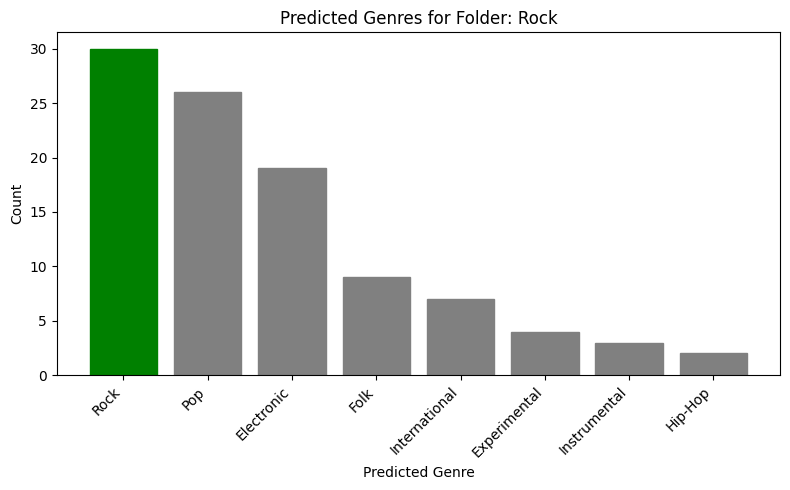

,Genre,RF,CNN,CNNv2
0,Rock,0.3,0.0,0.0


In [ ]:
# notebooks/classify_new_song.ipynb

#  Setup
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import joblib
import torch
from torchvision import transforms
from PIL import Image

USE_RF_ONLY = True  # Set to False to re-enable CNN and CNNv2

#  Paths
SONG_DIR = "../data/Songs/"
OUTPUT_DIR = "../reports/4_Classify_New_Song/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

RF_MODEL_PATH = "../models/rf_model.pkl"
CNN_BUNDLE_PATH = "../models/cnn_inference_bundle.pth"
CNNV2_BUNDLE_PATH = "../models/cnnv2_inference_bundle.pth"

#  Load Random Forest Model
rf_model = joblib.load(RF_MODEL_PATH)

#  CNN/CNNv2 Setup (Skip if RF-only) 
if not USE_RF_ONLY:
    # Load CNN Bundles
    cnn_bundle = torch.load(
        CNN_BUNDLE_PATH, map_location="cpu", weights_only=False)
    cnnv2_bundle = torch.load(
        CNNV2_BUNDLE_PATH, map_location="cpu", weights_only=False)

    cnn_transform = cnn_bundle['transform']
    cnnv2_transform = cnnv2_bundle['transform']

    cnn_classes = cnn_bundle['class_names']
    cnnv2_classes = cnnv2_bundle['class_names']

    # Define CNN Models
    class SimpleCNN(torch.nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.features = torch.nn.Sequential(
                torch.nn.Conv2d(3, 16, 3, 1, 1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(2),
                torch.nn.Conv2d(16, 32, 3, 1, 1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(2),
                torch.nn.Conv2d(32, 64, 3, 1, 1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(2)
            )
            self.classifier = torch.nn.Sequential(
                torch.nn.Flatten(),
                torch.nn.Linear(64 * 16 * 16, 128),
                torch.nn.ReLU(),
                torch.nn.Dropout(0.3),
                torch.nn.Linear(128, num_classes)
            )

        def forward(self, x):
            return self.classifier(self.features(x))

    class CNNv2(torch.nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.conv_block = torch.nn.Sequential(
                torch.nn.Conv2d(3, 32, 3, padding=1), torch.nn.BatchNorm2d(
                    32), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
                torch.nn.Conv2d(32, 64, 3, padding=1), torch.nn.BatchNorm2d(
                    64), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
                torch.nn.Conv2d(64, 128, 3, padding=1), torch.nn.BatchNorm2d(
                    128), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
                torch.nn.Conv2d(128, 256, 3, padding=1), torch.nn.BatchNorm2d(
                    256), torch.nn.ReLU(), torch.nn.MaxPool2d(2)
            )
            self.fc_block = torch.nn.Sequential(
                torch.nn.Flatten(),
                torch.nn.Linear(256 * 8 * 8, 512),
                torch.nn.ReLU(),
                torch.nn.Dropout(0.5),
                torch.nn.Linear(512, num_classes)
            )

        def forward(self, x):
            return self.fc_block(self.conv_block(x))

    # Initialize and load weights
    cnn_model = SimpleCNN(num_classes=len(cnn_classes))
    cnn_model.load_state_dict(cnn_bundle['model_state_dict'])
    cnn_model.eval()

    cnnv2_model = CNNv2(num_classes=len(cnnv2_classes))
    cnnv2_model.load_state_dict(cnnv2_bundle['model_state_dict'])
    cnnv2_model.eval()

#  Helpers 


def extract_mfcc(path):
    y, sr = librosa.load(path, sr=None, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    return np.concatenate([np.mean(mfcc, axis=1), np.std(mfcc, axis=1)])


def generate_spectrogram(path, save_path=None):
    y, sr = librosa.load(path, sr=None, duration=30)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    fig, ax = plt.subplots(figsize=(1.28, 1.28), dpi=100)
    librosa.display.specshow(S_dB, sr=sr, cmap='viridis', ax=ax)
    ax.axis('off')
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    return S_dB


def classify_image(model, image_tensor, class_names):
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0))
        probs = torch.nn.functional.softmax(output, dim=1).squeeze()
        return class_names[probs.argmax().item()], probs.numpy()

#  Inference Loop 


results = []

for genre_dir in os.listdir(SONG_DIR):
    genre_path = os.path.join(SONG_DIR, genre_dir)
    if not os.path.isdir(genre_path):
        continue

    for fname in os.listdir(genre_path):
        if not fname.endswith(".mp3"):
            continue
        fpath = os.path.join(genre_path, fname)
        base_name = os.path.splitext(fname)[0]

        try:
            #  Random Forest 
            mfcc_vector = extract_mfcc(fpath).reshape(1, -1)
            rf_pred = rf_model.predict(mfcc_vector)[0]

            # Default values if skipping CNNs
            cnn_pred = ""
            cnnv2_pred = ""

            if not USE_RF_ONLY:
                #  Spectrogram 
                spectro_path = os.path.join(
                    OUTPUT_DIR, f"{base_name}_spec.png")
                generate_spectrogram(fpath, save_path=spectro_path)

                img = Image.open(spectro_path).convert("RGB")

                #  CNN 
                cnn_input = cnn_transform(img)
                cnn_pred, cnn_probs = classify_image(
                    cnn_model, cnn_input, cnn_classes)

                #  CNNv2 
                cnnv2_input = cnnv2_transform(img)
                cnnv2_pred, cnnv2_probs = classify_image(
                    cnnv2_model, cnnv2_input, cnnv2_classes)

            # Save results
            results.append({
                "file": fname,
                "true_genre": genre_dir,
                "RF": rf_pred,
                "CNN": cnn_pred,
                "CNNv2": cnnv2_pred
            })

        except Exception as e:
            print(f"Error processing {fname}: {e}")

# Save results
df = pd.DataFrame(results)
df.to_csv(os.path.join(OUTPUT_DIR, "all_model_predictions.csv"), index=False)
df.head()


# Models to evaluate
models = {
    "RF": df["RF"],
    "CNN": df["CNN"],
    "CNNv2": df["CNNv2"]
}

true_labels = df["true_genre"]
labels_sorted = sorted(true_labels.unique())

for model_name, predictions in models.items():
    if (predictions == "").all():  # Skip unused models
        continue

    # Classification report text
    report = classification_report(
        true_labels, predictions, labels=labels_sorted, zero_division=0)
    report_path = os.path.join(
        OUTPUT_DIR, f"{model_name.lower()}_classification_report.txt")
    with open(report_path, "w") as f:
        f.write(report)

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=labels_sorted)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.colorbar()
    plt.xticks(np.arange(len(labels_sorted)),
               labels_sorted, rotation=45, ha='right')
    plt.yticks(np.arange(len(labels_sorted)), labels_sorted)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(
        OUTPUT_DIR, f"{model_name.lower()}_confusion_matrix.png"))
    plt.close()

    # Bar charts for precision, recall, F1, support
    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, predictions, labels=labels_sorted, zero_division=0
    )

    metrics = {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Support": support
    }

    for metric_name, values in metrics.items():
        plt.figure(figsize=(10, 5))
        plt.bar(labels_sorted, values)
        plt.title(f"{metric_name} per Genre - {model_name}")
        plt.ylabel(metric_name)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        fname = f"{model_name.lower()}_{metric_name.lower().replace('-', '_')}_bar.png"
        plt.savefig(os.path.join(OUTPUT_DIR, fname))
        plt.close()